
Data ready for clustering: 43,903 players × 64 features


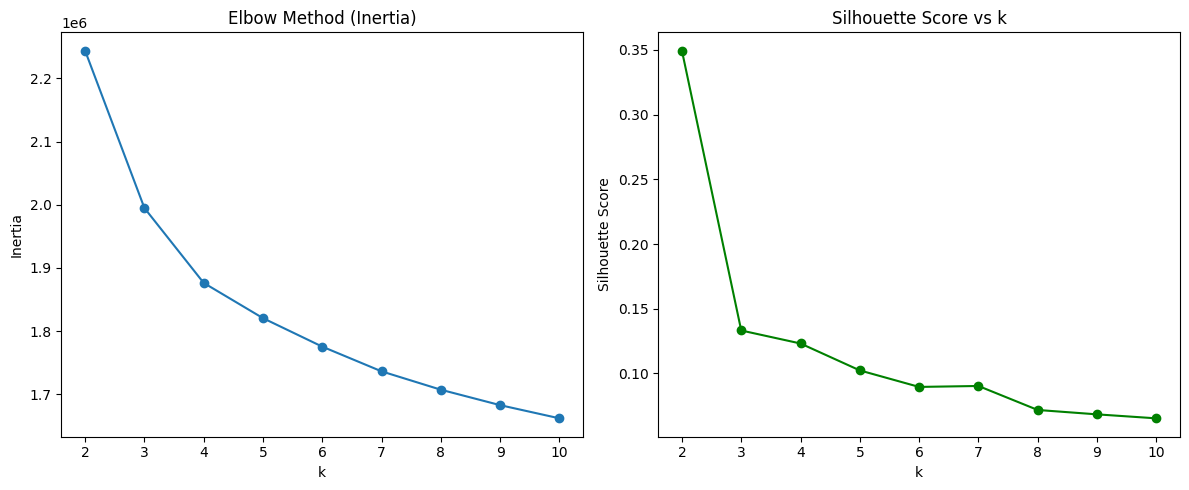


Best k (Silhouette): 2


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ===================================================================
# CONFIGURATION
# ===================================================================
FILE_PATH = r"C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"

# ===================================================================
# Load data
# ===================================================================
df = pd.read_excel(FILE_PATH)

# Columns to drop (No-Age configuration)
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat', 'Age'
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Separate features and target
if "success_label" in df.columns:
    y = df["success_label"]
    X = df.drop(columns=["success_label"])
else:
    y = None
    X = df.copy()

# ===================================================================
# Standardize features
# ===================================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nData ready for clustering: {X.shape[0]:,} players × {X.shape[1]} features")

# ===================================================================
# K-Means (Elbow + Silhouette)
# ===================================================================
K_RANGE = range(2, 11)
inertia = []
sil_scores = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=67, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot inertia + silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(K_RANGE, inertia, marker="o")
ax[0].set_title("Elbow Method (Inertia)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(K_RANGE, sil_scores, marker="o", color="green")
ax[1].set_title("Silhouette Score vs k")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

best_k = K_RANGE[np.argmax(sil_scores)]
print(f"\nBest k (Silhouette): {best_k}")

# ===================================================================
# Fit final clustering model
# ===================================================================
kmeans_final = KMeans(n_clusters=best_k, random_state=67, n_init=20)
cluster_labels = kmeans_final.fit_predict(X_scaled)

df["cluster"] = cluster_labels

In [65]:
# ===================================================================
# Cluster statistics
# ===================================================================
print("\nCluster Sizes:")
print(df["cluster"].value_counts().sort_index())

# Percentage successful players per cluster
if y is not None:
    df["success_label"] = y
    success_pct = df.groupby("cluster")["success_label"].mean() * 100
    print("\nSuccess percentage per cluster:")
    print(success_pct)

# Cluster centroids (inverse transform back to original scale)
centroids_std = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_std)
centroids_df = pd.DataFrame(centroids_original, columns=X.columns)

print("\nCluster centroids (original scale):")
print(centroids_df.round(3))

# Mean & SD per cluster
cluster_stats = df.groupby("cluster")[X.columns].agg(["mean", "std"])
print("\nMean & SD per cluster:")
print(cluster_stats.round(3))


Cluster Sizes:
cluster
0     4631
1    39272
Name: count, dtype: int64

Success percentage per cluster:
cluster
0    4.729000
1    3.116724
Name: success_label, dtype: float64

Cluster centroids (original scale):
       CA       PA     Acc     Ada     Agg     Aer     Amb  ...    Vis    Vers   Nat.1     Jum     Wor  Weight   Height
0  72.883  101.048   9.768  13.091   9.207  10.468  11.019  ...  6.066   9.490  11.908  11.242   6.493  77.064  187.517
1  77.899  104.454  11.802  13.005  10.233   2.097  11.102  ...  8.265  11.186  11.931   8.748  10.131  70.869  179.521

[2 rows x 64 columns]

Mean & SD per cluster:
             CA               PA             Acc            Ada  ...    Jum     Wor         Weight          Height       
           mean     std     mean     std    mean    std    mean  ...    std    mean    std    mean    std     mean    std
cluster                                                          ...                                                     
0        72.8

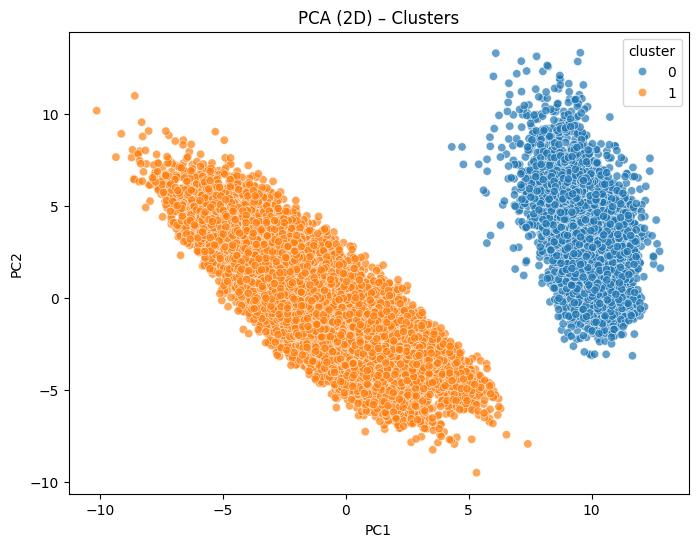

In [66]:
# ===================================================================
# PCA Visualization (2D)
# ===================================================================
pca = PCA(n_components=2, random_state=67)
pca_comp = pca.fit_transform(X_scaled)

df["PC1"] = pca_comp[:, 0]
df["PC2"] = pca_comp[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.7)
plt.title("PCA (2D) – Clusters")
plt.show()

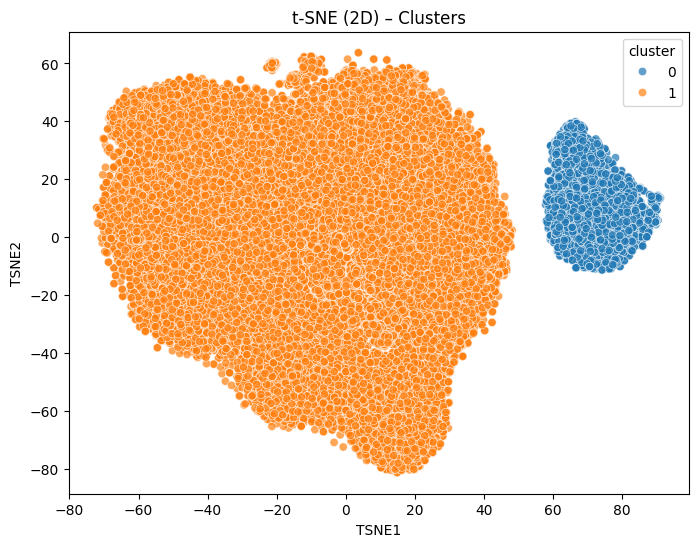

In [67]:
# ===================================================================
# t-SNE Visualization (2D)
# ===================================================================
tsne = TSNE(n_components=2, perplexity=30, random_state=67)
tsne_comp = tsne.fit_transform(X_scaled)

df["TSNE1"] = tsne_comp[:, 0]
df["TSNE2"] = tsne_comp[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="cluster", palette="tab10", alpha=0.7)
plt.title("t-SNE (2D) – Clusters")
plt.show()

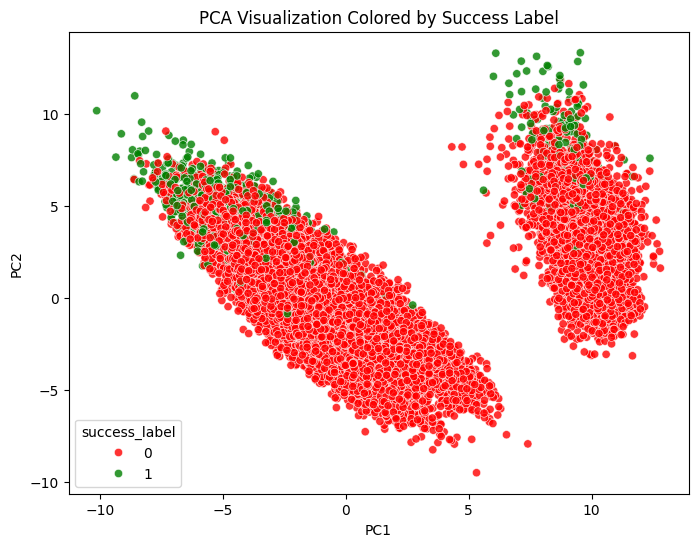

In [5]:
# PCA colored by success
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, x="PC1", y="PC2",
    hue="success_label", palette={0:"red", 1:"green"}, alpha=0.8
)
plt.title("PCA Visualization Colored by Success Label")
plt.show()

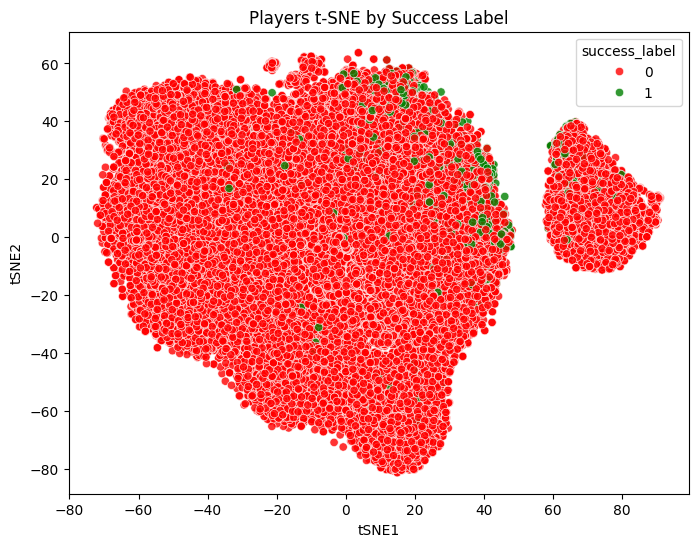

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=67, perplexity=30, max_iter=1000)
tsne_components = tsne.fit_transform(X_scaled)

df["tSNE1"], df["tSNE2"] = tsne_components[:, 0], tsne_components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, x="tSNE1", y="tSNE2",
    hue="success_label", palette={0:"red", 1:"green"}, alpha=0.8
)
plt.title("Players t-SNE by Success Label")
plt.show()

Data: 43903 players × 2 features


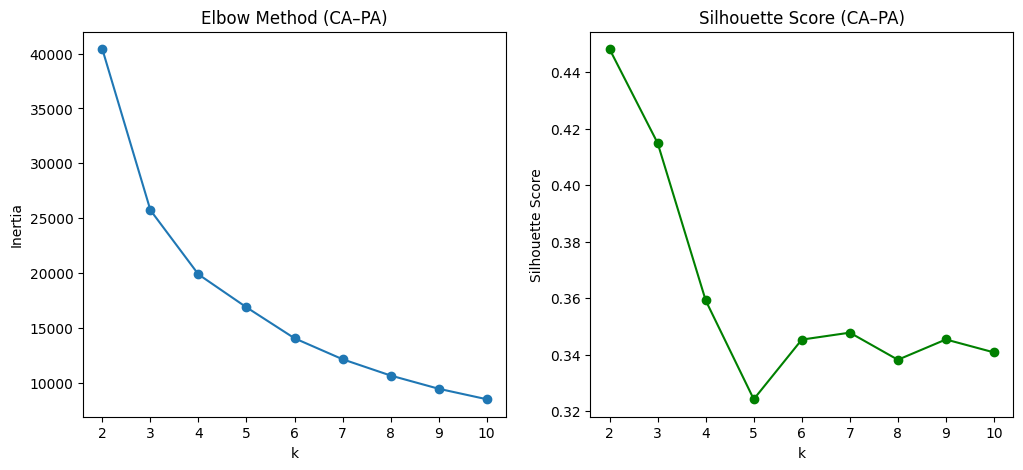

Best k (Silhouette): 2


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# =============================
# Load Data
# =============================
df = df.copy()  # use the existing df in memory

# Keep only CA, PA, success_label
req_cols = ["CA", "PA", "success_label"]
data = df[[c for c in req_cols if c in df.columns]].dropna()

X = data[["CA", "PA"]]
y = data["success_label"]

# =============================
# Standardize
# =============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Data: {X.shape[0]} players × {X.shape[1]} features")

# =============================
# KMeans: Elbow + Silhouette
# =============================
K_RANGE = range(2, 11)
inertia = []
sil_scores = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=67, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(K_RANGE, inertia, marker="o")
ax[0].set_title("Elbow Method (CA–PA)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(K_RANGE, sil_scores, marker="o", color="green")
ax[1].set_title("Silhouette Score (CA–PA)")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette Score")
plt.show()

best_k = K_RANGE[np.argmax(sil_scores)]
print(f"Best k (Silhouette): {best_k}")

# =============================
# Final Clustering
# =============================
kmeans_final = KMeans(n_clusters=best_k, random_state=67, n_init=20)
clusters = kmeans_final.fit_predict(X_scaled)

data["cluster"] = clusters

In [10]:
# =============================
# Final Clustering
# =============================
kmeans_final = KMeans(n_clusters=best_k, random_state=67, n_init=20)
clusters = kmeans_final.fit_predict(X_scaled)

data["cluster"] = clusters

# =============================
# Cluster sizes
# =============================
print("\nCluster Sizes:")
print(data["cluster"].value_counts().sort_index())

# =============================
# Success Percentage per Cluster
# =============================
success_pct = data.groupby("cluster")["success_label"].mean() * 100
print("\nSuccess Percentage per Cluster:")
print(success_pct.round(2))

# =============================
# Centroids (Original Scale)
# =============================
centroids_std = kmeans_final.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_std)

centroids_df = pd.DataFrame(centroids_orig, columns=["CA", "PA"])
print("\nCluster Centroids (Original Scale):")
print(centroids_df.round(2))

# =============================
# Mean ± SD per Cluster
# =============================
cluster_mean = data.groupby("cluster")[["CA", "PA"]].mean()
cluster_std  = data.groupby("cluster")[["CA", "PA"]].std()

cluster_descriptives = pd.concat(
    [cluster_mean.add_suffix("_mean"), cluster_std.add_suffix("_std")],
    axis=1
)
print("\nMean ± SD per Cluster:")
print(cluster_descriptives.round(2))


Cluster Sizes:
cluster
0    22365
1    21538
Name: count, dtype: int64

Success Percentage per Cluster:
cluster
0    0.21
1    6.48
Name: success_label, dtype: float64

Cluster Centroids (Original Scale):
      CA      PA
0  63.40   89.00
1  91.81  119.69

Mean ± SD per Cluster:
         CA_mean  PA_mean  CA_std  PA_std
cluster                                  
0          63.43    89.04   11.49   14.32
1          91.85   119.73   14.93   13.62


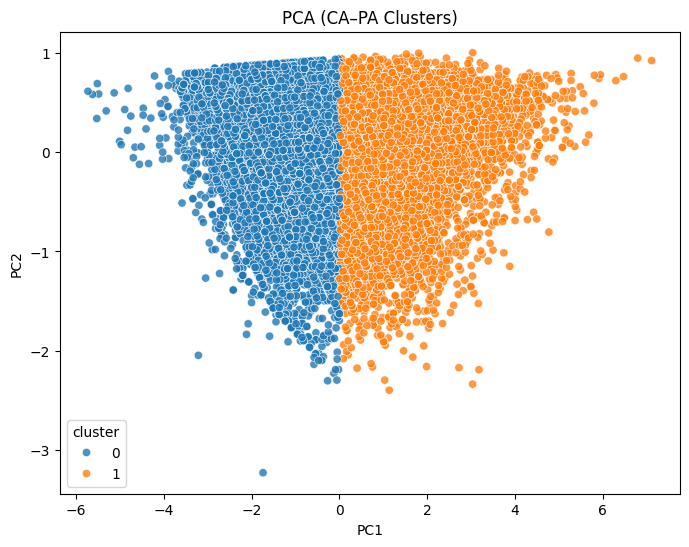

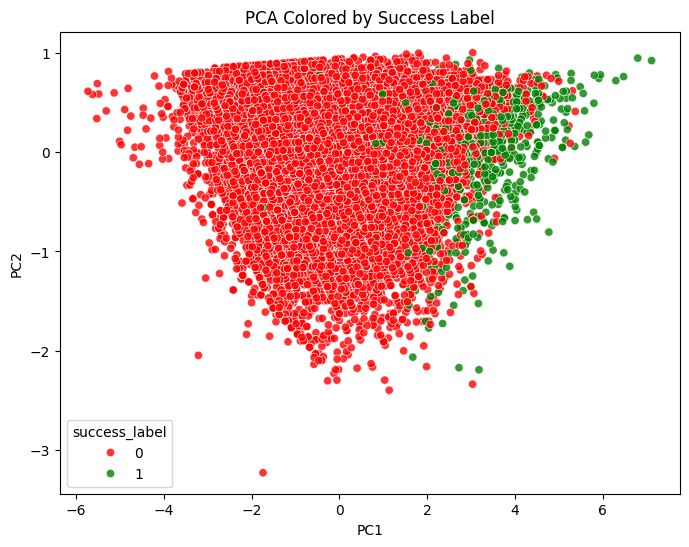

In [11]:
# =============================
# PCA Visualization
# =============================
pca = PCA(n_components=2, random_state=67)
pca_comp = pca.fit_transform(X_scaled)
data["PC1"], data["PC2"] = pca_comp[:,0], pca_comp[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=data, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.8)
plt.title("PCA (CA–PA Clusters)")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=data, x="PC1", y="PC2", hue="success_label",
                palette={0:"red",1:"green"}, alpha=0.8)
plt.title("PCA Colored by Success Label")
plt.show()

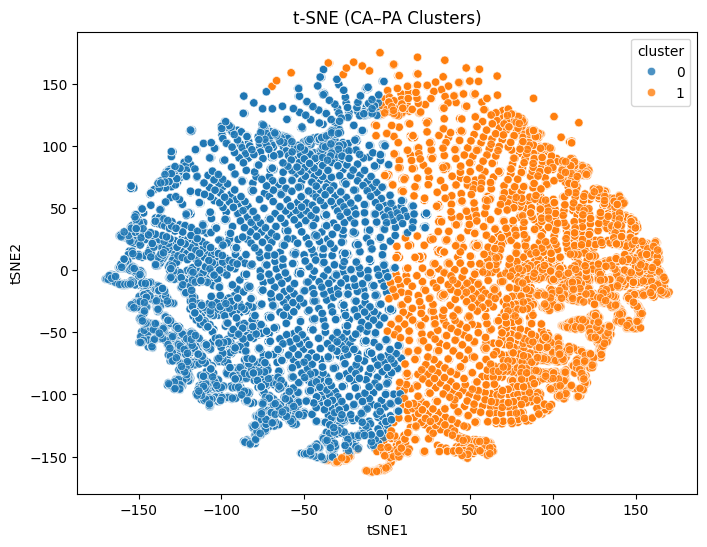

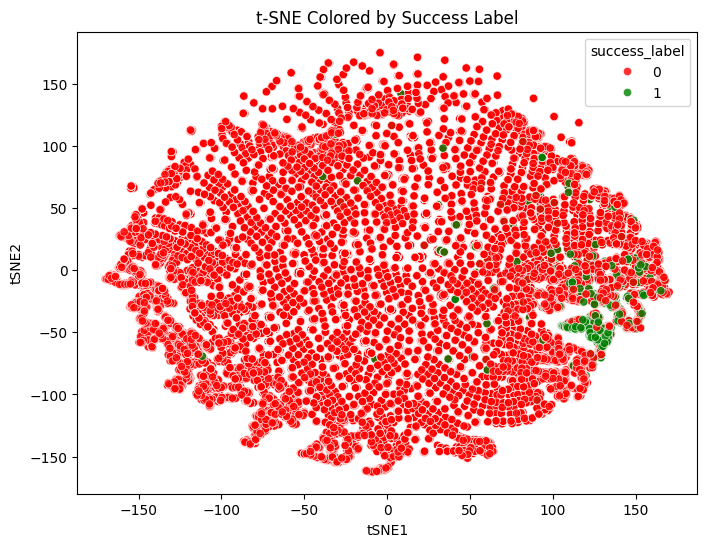

In [13]:
# =============================
# t-SNE Visualization
# =============================
tsne = TSNE(n_components=2, perplexity=30, random_state=67)
ts = tsne.fit_transform(X_scaled)
data["tSNE1"], data["tSNE2"] = ts[:,0], ts[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=data, x="tSNE1", y="tSNE2", hue="cluster", palette="tab10", alpha=0.8)
plt.title("t-SNE (CA–PA Clusters)")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=data, x="tSNE1", y="tSNE2", hue="success_label",
                palette={0:"red",1:"green"}, alpha=0.8)
plt.title("t-SNE Colored by Success Label")
plt.show()

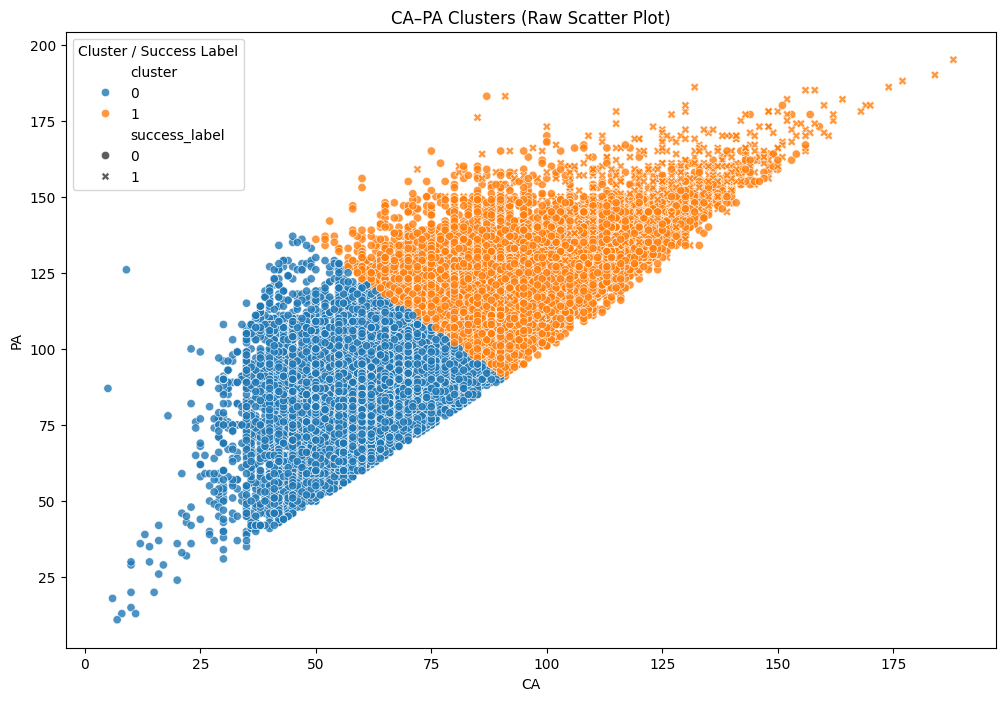

In [25]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=data, x='CA', y='PA',
    hue='cluster', style='success_label',
    palette='tab10', alpha=0.8
)
plt.title("CA–PA Clusters (Raw Scatter Plot)")
plt.legend(title="Cluster / Success Label")
plt.show()

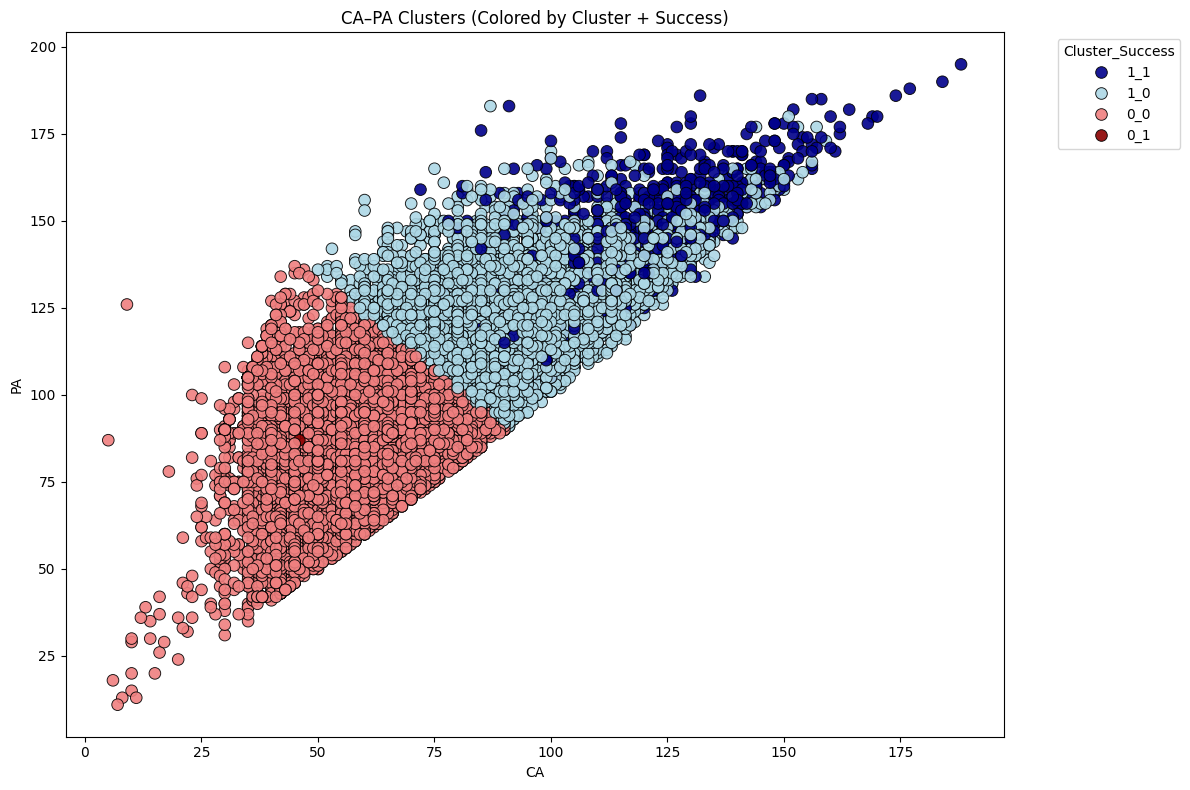

In [26]:
# Create combined label for color coding
data['color_label'] = data['cluster'].astype(str) + '_' + data['success_label'].astype(str)

# Custom palette for cluster + success combinations
palette = {
    '0_0':'lightcoral',   # Cluster 0, Fail
    '0_1':'darkred',      # Cluster 0, Success
    '1_0':'lightblue',    # Cluster 1, Fail
    '1_1':'darkblue'      # Cluster 1, Success
}

# Plot CA–PA with custom palette
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=data, x='CA', y='PA',
    hue='color_label', palette=palette,
    alpha=0.9, s=70, edgecolor='black'
)
plt.title("CA–PA Clusters (Colored by Cluster + Success)")
plt.legend(title="Cluster_Success", bbox_to_anchor=(1.05,1), loc=2)
plt.tight_layout()
plt.show()

Using 43,903 players for CA–PA clustering.


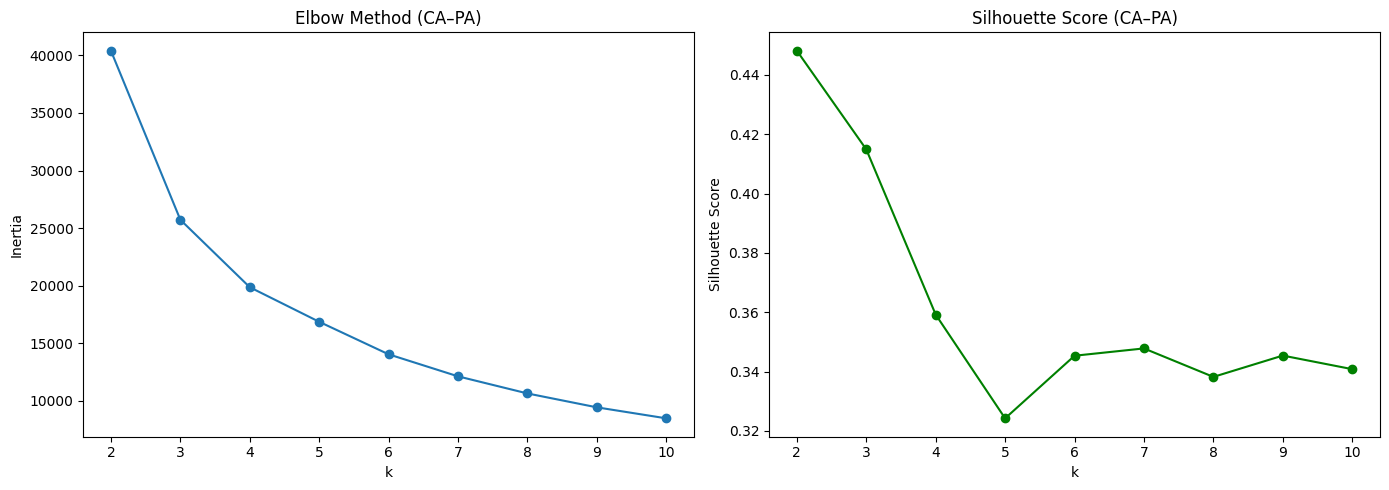


Best k (Silhouette Score): 2

Cluster sizes:
cluster
0    22365
1    21538
Name: count, dtype: int64


In [28]:
# ======================================================
# CA–PA Clustering with Transfer Value Visualization
# ======================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# ======================================================
# Load data
# ======================================================
df = pd.read_excel(
    r"C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
)

# Keep only required columns
cols = ["CA", "PA", "Transfer Value", "success_label"]
data = df[cols].dropna()

# Extract features
X = data[["CA", "PA"]]
y = data["success_label"]
value = data["Transfer Value"]

print(f"Using {len(data):,} players for CA–PA clustering.")

# ======================================================
# Standardize CA and PA
# ======================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======================================================
# Elbow Method + Silhouette Score
# ======================================================
K_RANGE = range(2, 11)
inertia = []
silhouette_scores = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=67, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot Elbow + Silhouette
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# Elbow Method
ax[0].plot(K_RANGE, inertia, marker="o")
ax[0].set_title("Elbow Method (CA–PA)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

# Silhouette Score
ax[1].plot(K_RANGE, silhouette_scores, marker="o", color="green")
ax[1].set_title("Silhouette Score (CA–PA)")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# Determine best_k from silhouette
best_k = K_RANGE[np.argmax(silhouette_scores)]
print(f"\nBest k (Silhouette Score): {best_k}")

# ======================================================
# Fit final KMeans model
# ======================================================
kmeans = KMeans(n_clusters=best_k, random_state=67, n_init=20)
data["cluster"] = kmeans.fit_predict(X_scaled)

print("\nCluster sizes:")
print(data["cluster"].value_counts())

In [29]:
# ======================================================
# Success percentage per cluster
# ======================================================
success_pct = data.groupby("cluster")["success_label"].mean() * 100
print("\nSuccess percentage per cluster:")
print(success_pct.round(2))

# ======================================================
# Cluster centroids (original scale)
# ======================================================
centroids_std = kmeans.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_std)

centroids_df = pd.DataFrame(centroids_orig, columns=["CA", "PA"])
print("\nCluster Centroids (Original CA–PA Values):")
print(centroids_df.round(2))

# ======================================================
# Mean ± SD per cluster
# ======================================================
cluster_mean = data.groupby("cluster")[["CA", "PA"]].mean()
cluster_std  = data.groupby("cluster")[["CA", "PA"]].std()

cluster_stats = pd.concat(
    [cluster_mean.add_suffix("_mean"), cluster_std.add_suffix("_std")],
    axis=1
)

print("\nMean ± SD per cluster:")
print(cluster_stats.round(2))


Success percentage per cluster:
cluster
0    0.21
1    6.48
Name: success_label, dtype: float64

Cluster Centroids (Original CA–PA Values):
      CA      PA
0  63.40   89.00
1  91.81  119.69

Mean ± SD per cluster:
         CA_mean  PA_mean  CA_std  PA_std
cluster                                  
0          63.43    89.04   11.49   14.32
1          91.85   119.73   14.93   13.62


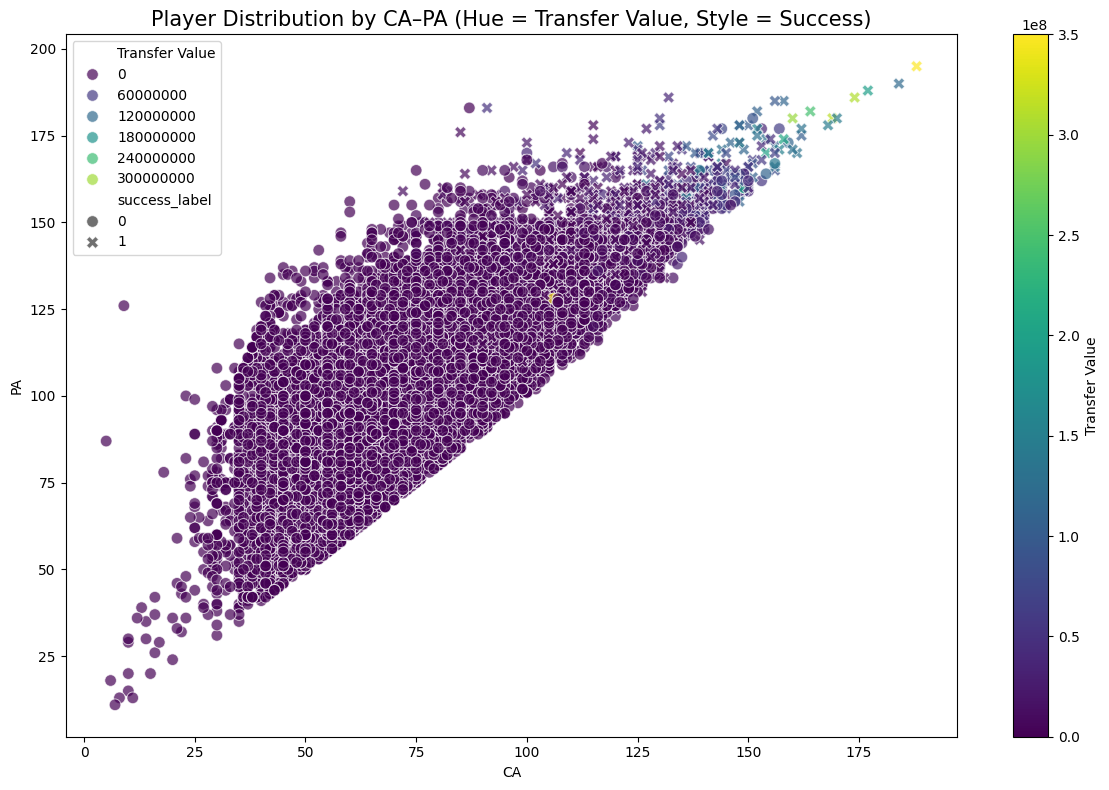

In [45]:
# ======================================================
# Visualization 1: CA–PA (Hue = Transfer Value, Style = Success)
# ======================================================

plt.figure(figsize=(12,8))
scatter = sns.scatterplot(
    data=data,
    x="CA", y="PA",
    hue="Transfer Value",
    style="success_label",
    palette="viridis",
    s=70, alpha=0.7
)

plt.title("Player Distribution by CA–PA (Hue = Transfer Value, Style = Success)", fontsize=15)

# Fix colorbar issue
norm = plt.Normalize(data["Transfer Value"].min(), data["Transfer Value"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=plt.gca(), label="Transfer Value")
plt.tight_layout()
plt.show()

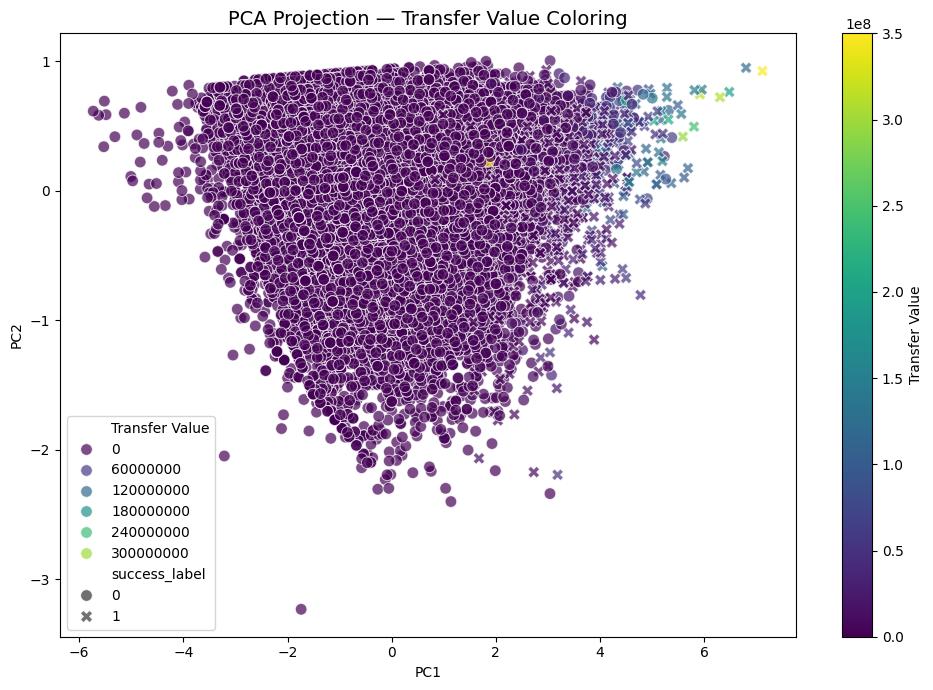

In [46]:
# ======================================================
# PCA Visualization (Transfer Value Colors)
# ======================================================

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=data,
    x="PC1", y="PC2",
    hue="Transfer Value",
    style="success_label",
    palette="viridis",
    s=70, alpha=0.7
)

plt.title("PCA Projection — Transfer Value Coloring", fontsize=14)

# Add colorbar
norm = plt.Normalize(data["Transfer Value"].min(), data["Transfer Value"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label="Transfer Value")

plt.tight_layout()
plt.show()

In [41]:
# ======================================================
# Compute t-SNE
# ======================================================
tsne = TSNE(n_components=2, perplexity=30, random_state=67)
tsne_comp = tsne.fit_transform(X_scaled)

data["tSNE1"] = tsne_comp[:, 0]
data["tSNE2"] = tsne_comp[:, 1]

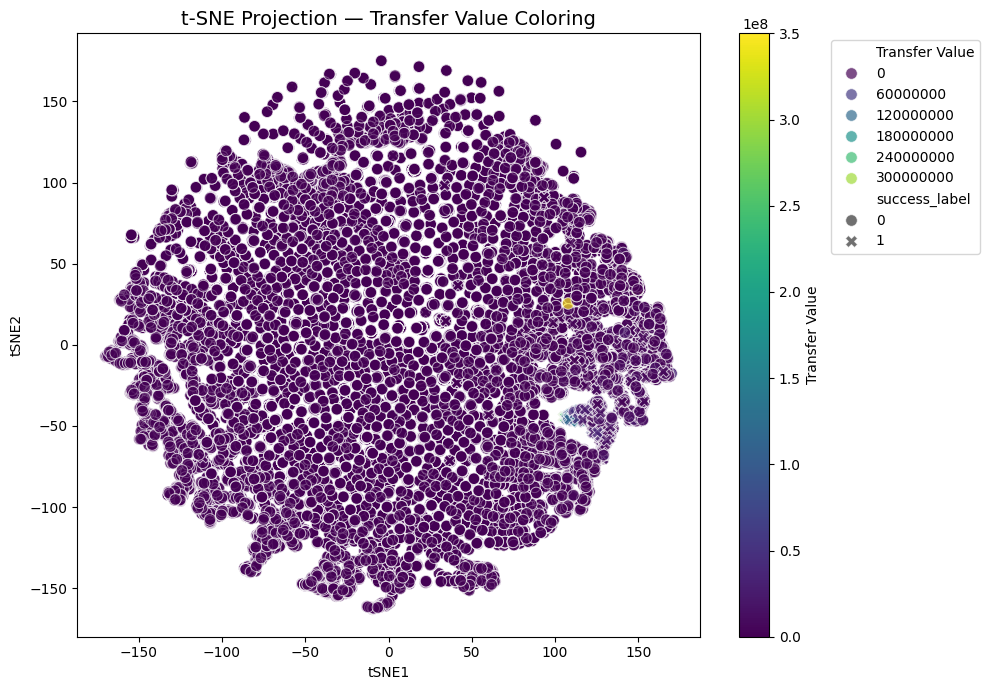

In [49]:
plt.figure(figsize=(10,7))
ax = sns.scatterplot(
    data=data,
    x="tSNE1", y="tSNE2",
    hue="Transfer Value",
    style="success_label",
    palette="viridis",
    s=70, alpha=0.7
)

plt.title("t-SNE Projection — Transfer Value Coloring", fontsize=14)

norm = plt.Normalize(data["Transfer Value"].min(), data["Transfer Value"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left')

plt.colorbar(sm, ax=ax, label="Transfer Value")
plt.tight_layout()
plt.show()

Using 43,903 players for Total_Score–TransferValue clustering.


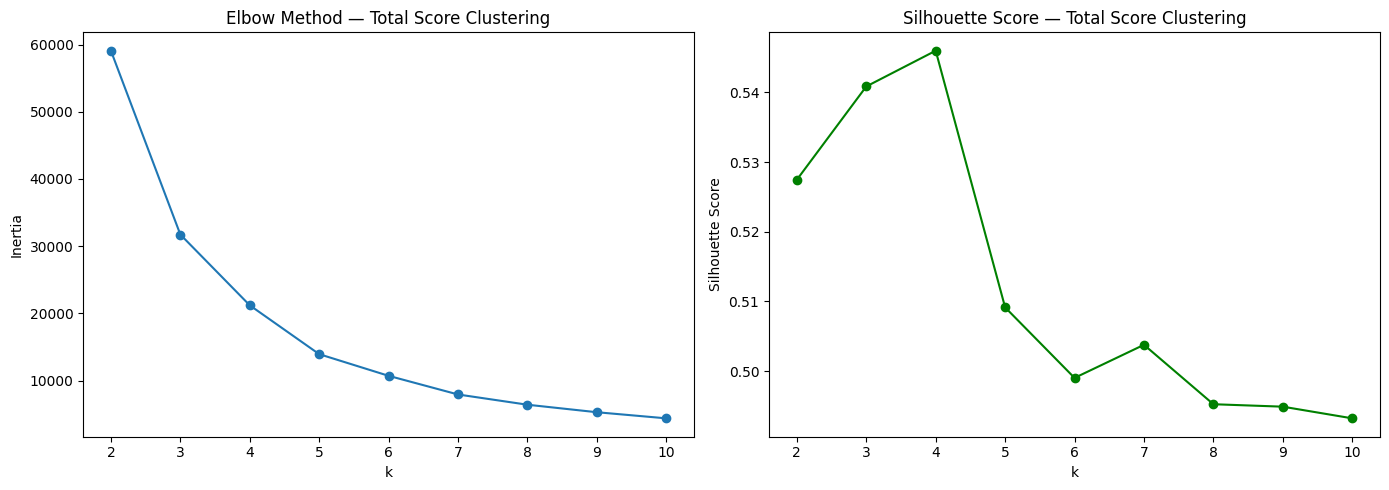


Best k based on Silhouette = 4

Cluster Sizes:
cluster
0    23799
1    19878
2      208
3       18
Name: count, dtype: int64


In [50]:
# ======================================================
# TOTAL SCORE + TRANSFER VALUE CLUSTERING
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ======================================================
# Load Data
# ======================================================
df = pd.read_excel(
    r"C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
)

# Calculate Total_Score from Acc → Wor
cols_to_sum = df.loc[:, "Acc":"Wor"].columns
df["Total_Score"] = df[cols_to_sum].sum(axis=1)

# Keep relevant columns
cols = ["Total_Score", "Transfer Value", "success_label"]
data = df[cols].dropna()

# Features
X = data[["Total_Score", "Transfer Value"]]
y = data["success_label"]

print(f"Using {len(data):,} players for Total_Score–TransferValue clustering.")

# ======================================================
# Standardize
# ======================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======================================================
# Elbow + Silhouette
# ======================================================
K_RANGE = range(2, 11)
inertia = []
sil_scores = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=67, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(K_RANGE, inertia, marker="o")
ax[0].set_title("Elbow Method — Total Score Clustering")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(K_RANGE, sil_scores, marker="o", color="green")
ax[1].set_title("Silhouette Score — Total Score Clustering")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

best_k = K_RANGE[np.argmax(sil_scores)]
print(f"\nBest k based on Silhouette = {best_k}")

# ======================================================
# Final Clustering
# ======================================================
kmeans_final = KMeans(n_clusters=best_k, random_state=67, n_init=20)
data["cluster"] = kmeans_final.fit_predict(X_scaled)

print("\nCluster Sizes:")
print(data["cluster"].value_counts())

In [51]:
# Success %
print("\nSuccess Percentage per Cluster:")
print((data.groupby("cluster")["success_label"].mean() * 100).round(2))

# Centroids (original scale)
centroids_scaled = kmeans_final.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_scaled)

print("\nCluster Centroids (Original Scale):")
print(pd.DataFrame(centroids_orig, columns=["Total_Score", "Transfer Value"]).round(2))

# Mean ± SD
cluster_mean = data.groupby("cluster")[["Total_Score", "Transfer Value"]].mean()
cluster_std  = data.groupby("cluster")[["Total_Score", "Transfer Value"]].std()
cluster_stats = pd.concat([cluster_mean.add_suffix("_mean"), cluster_std.add_suffix("_std")], axis=1)

print("\nMean ± SD per Cluster:")
print(cluster_stats.round(2))


Success Percentage per Cluster:
cluster
0     0.36
1     6.09
2    65.87
3    55.56
Name: success_label, dtype: float64

Cluster Centroids (Original Scale):
   Total_Score  Transfer Value
0       434.33    1.021724e+05
1       514.22    1.019959e+06
2       609.17    7.209375e+07
3       614.83    3.041944e+08

Mean ± SD per Cluster:
         Total_Score_mean  Transfer Value_mean  Total_Score_std  Transfer Value_std
cluster                                                                            
0                  434.33         1.021724e+05            28.67           349151.40
1                  514.22         1.019959e+06            30.17          2983527.47
2                  609.17         7.209375e+07            31.18         31626627.77
3                  614.83         3.041944e+08            79.41         62134138.31


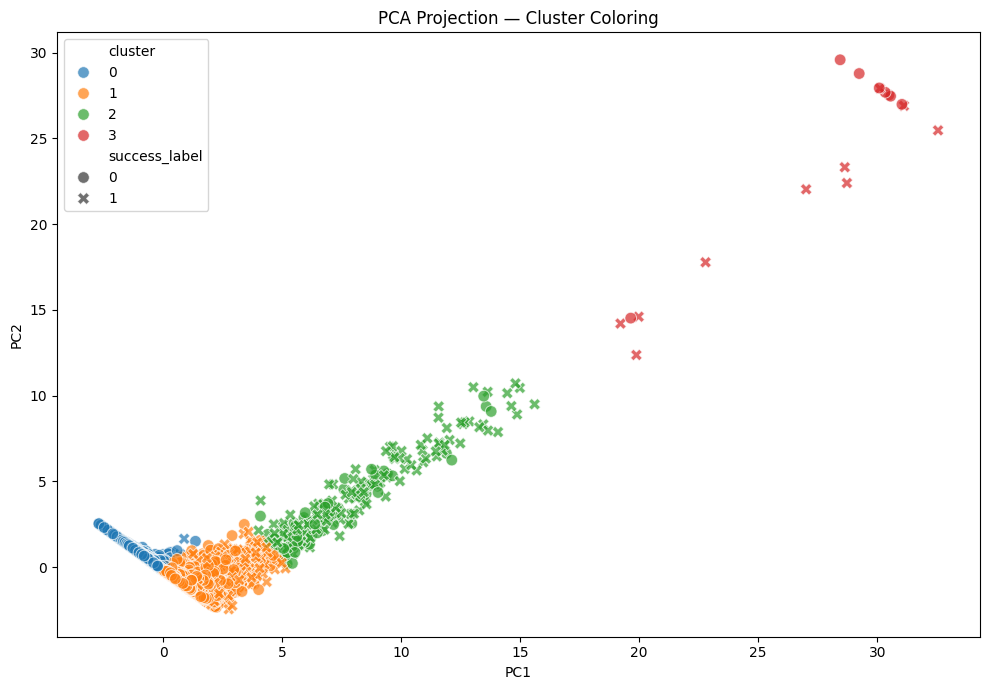

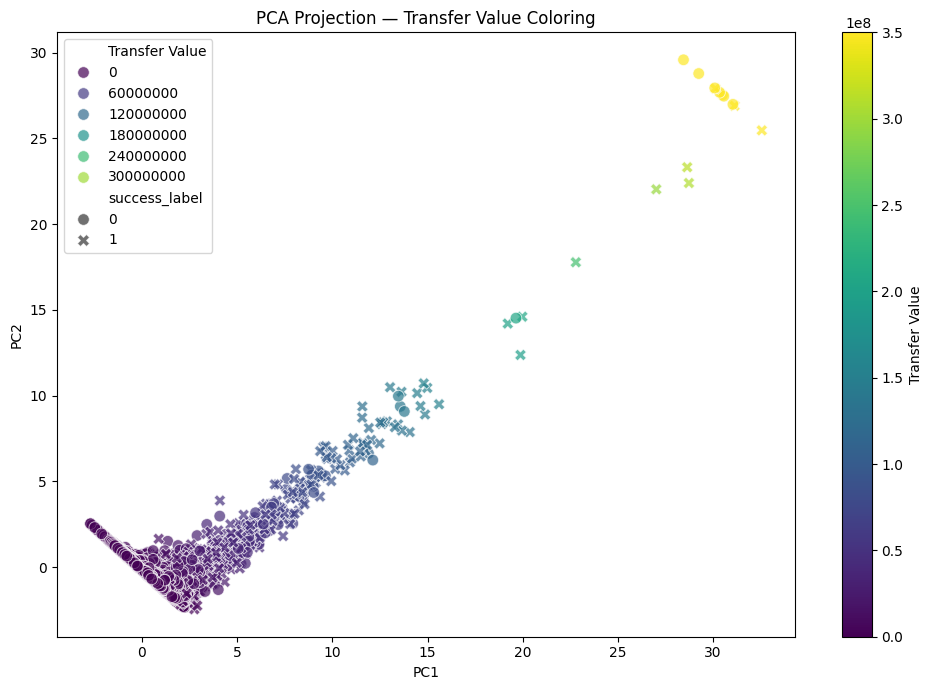

In [56]:
# ======================================================
# PCA
# ======================================================
pca = PCA(n_components=2, random_state=67)
pca_comp = pca.fit_transform(X_scaled)

data["PC1"] = pca_comp[:, 0]
data["PC2"] = pca_comp[:, 1]

# PCA (Normal Colors)
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=data,
    x="PC1", y="PC2",
    hue="cluster",
    style="success_label",
    palette="tab10",
    s=70, alpha=0.7
)
plt.title("PCA Projection — Cluster Coloring")
plt.tight_layout()
plt.show()

# PCA (Transfer Value Colors)
plt.figure(figsize=(10,7))
ax = sns.scatterplot(
    data=data,
    x="PC1", y="PC2",
    hue="Transfer Value",
    style="success_label",
    palette="viridis",
    s=70, alpha=0.7
)
plt.title("PCA Projection — Transfer Value Coloring")

norm = plt.Normalize(data["Transfer Value"].min(), data["Transfer Value"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Transfer Value")

plt.tight_layout()
plt.show()

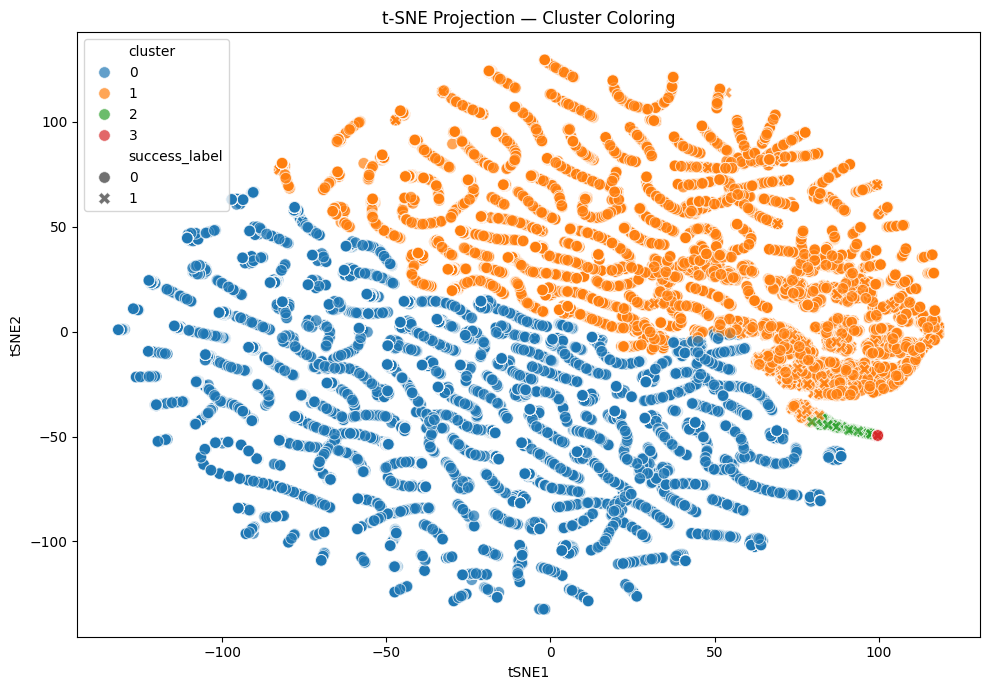

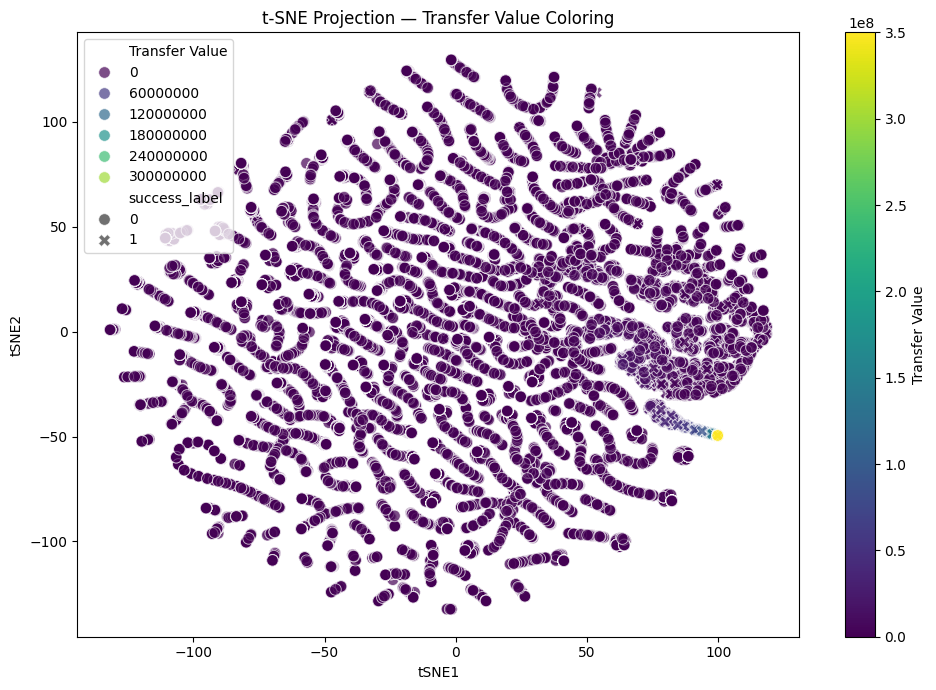

In [57]:
# ======================================================
# t-SNE
# ======================================================
tsne = TSNE(n_components=2, perplexity=30, random_state=67)
tsne_comp = tsne.fit_transform(X_scaled)

data["tSNE1"] = tsne_comp[:, 0]
data["tSNE2"] = tsne_comp[:, 1]

# t-SNE (Normal)
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=data,
    x="tSNE1", y="tSNE2",
    hue="cluster",
    style="success_label",
    palette="tab10",
    s=70, alpha=0.7
)
plt.title("t-SNE Projection — Cluster Coloring")
plt.tight_layout()
plt.show()

# t-SNE (Transfer Value Colors)
plt.figure(figsize=(10,7))
ax = sns.scatterplot(
    data=data,
    x="tSNE1", y="tSNE2",
    hue="Transfer Value",
    style="success_label",
    palette="viridis",
    s=70, alpha=0.7
)
plt.title("t-SNE Projection — Transfer Value Coloring")

norm = plt.Normalize(data["Transfer Value"].min(), data["Transfer Value"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Transfer Value")

plt.tight_layout()
plt.show()

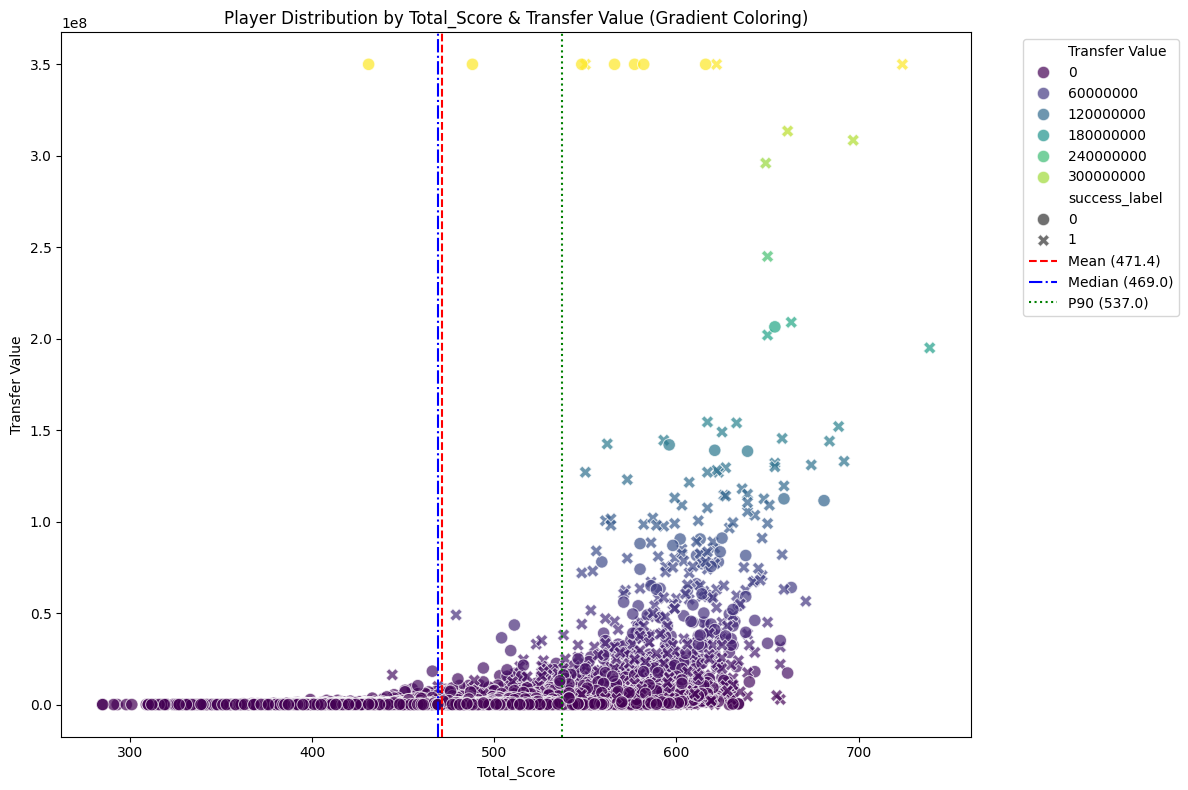

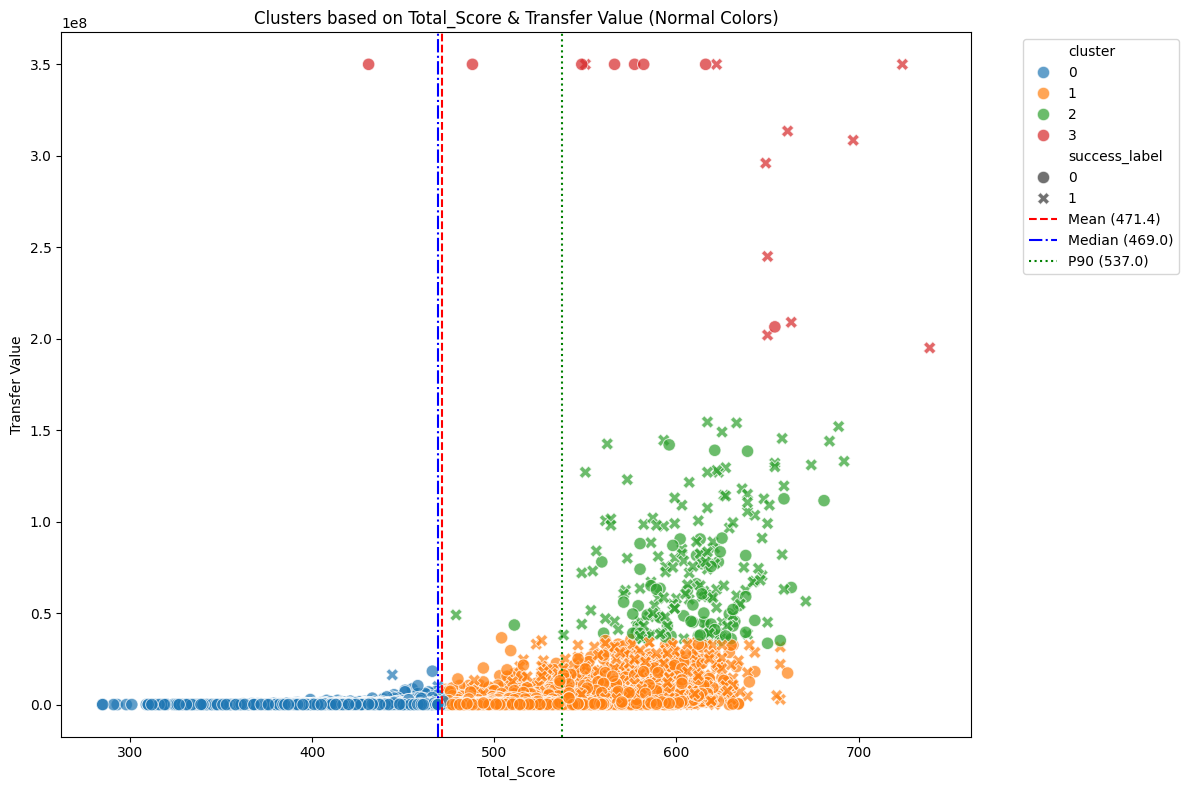

In [62]:
# ======================================================
# Raw Scatter (Total Score vs Value) — BOTH Plots with Lines Added
# ======================================================

mean_total = data["Total_Score"].mean()
median_total = data["Total_Score"].median()
p90_total = data["Total_Score"].quantile(0.9)

# ------------------------------
# Transfer Value Gradient Plot
# ------------------------------
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=data,
    x="Total_Score", y="Transfer Value",
    hue="Transfer Value",
    style="success_label",
    palette="viridis",
    s=80, alpha=0.7
)

# Add vertical lines
plt.axvline(mean_total, color='red', linestyle='--', label=f"Mean ({mean_total:.1f})")
plt.axvline(median_total, color='blue', linestyle='-.', label=f"Median ({median_total:.1f})")
plt.axvline(p90_total, color='green', linestyle=':', label=f"P90 ({p90_total:.1f})")

plt.title("Player Distribution by Total_Score & Transfer Value (Gradient Coloring)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ------------------------------
# Cluster Colors Plot
# ------------------------------
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=data,
    x="Total_Score", y="Transfer Value",
    hue="cluster",
    style="success_label",
    palette="tab10",
    s=80, alpha=0.7
)

# Add vertical lines 
plt.axvline(mean_total, color='red', linestyle='--', label=f"Mean ({mean_total:.1f})")
plt.axvline(median_total, color='blue', linestyle='-.', label=f"Median ({median_total:.1f})")
plt.axvline(p90_total, color='green', linestyle=':', label=f"P90 ({p90_total:.1f})")

plt.title("Clusters based on Total_Score & Transfer Value (Normal Colors)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
